<a href="https://colab.research.google.com/github/Peckkie/NanoX/blob/main/Data_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# คำสั่ง  drive.mount : เป็นผูก google drive กับ colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir( '/content/drive/MyDrive/NanoX')
!pwd 

/content/drive/MyDrive/NanoX


In [3]:
!pip install azure-storage-blob==2.1.0

     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 3.2 MB 27.9 MB/s 


In [4]:
from azure.storage.blob import BlockBlobService
import os

In [37]:
blob_service_client = BlockBlobService(account_name='dent01', account_key='CuShY0B4TZJ84TjzPpaHxyrHOpO73aGXeCpdVq7x26OjIlQ1HOz+3DVc9pDEj9BdcEL8odFuTRF0mOAE+aCgiw==')

In [38]:
img_name = 'DA0638BF-B906-4461-8905-2446B3148611.png'#'6704FF24-1C79-4EF9-BDBD-25BE33015A3A.png'
full_path_to_file2 = os.path.join(img_name)
blob_service_client.get_blob_to_path('nano', full_path_to_file2, full_path_to_file2)

In [60]:
import pandas as pd
import numpy as np
import os

In [61]:
path = '/content/drive/MyDrive/NanoX/'

In [62]:
data_pd = pd.read_excel('/content/drive/MyDrive/NanoX/Smartphone based sensor_19 August 2021.xlsx',sheet_name=0)
data_pd.head()

,NO.,plate 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Name :,plate 1,NaN,NaN,NaN,NaN,NaN,Image file name,NaN,6704FF24-1C79-4EF9-BDBD-25BE33015A3A.png,NaN,NaN,NaN,NaN
1,Date :,2021-08-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DA0638BF-B906-4461-8905-2446B3148611.png,NaN,NaN,NaN,NaN
2,NaN,Baseline,NaN,0,NaN,NaN,NaN,NaN,NaN,AD52FD2E-B239-474F-A673-F54C8D5CF5E3.png,NaN,NaN,NaN,NaN
3,NaN,Normal DNA,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Cancer DNA,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
label = data_pd.iloc[12,3:12:2] 
fname = data_pd.iloc[:3,9]

In [28]:
label

Unnamed: 3     -1
Unnamed: 5      1
Unnamed: 7     -1
Unnamed: 9      1
Unnamed: 11    -1
Name: 12, dtype: object

In [29]:
fname

0    6704FF24-1C79-4EF9-BDBD-25BE33015A3A.png
1    DA0638BF-B906-4461-8905-2446B3148611.png
2    AD52FD2E-B239-474F-A673-F54C8D5CF5E3.png
Name: Unnamed: 9, dtype: object

In [66]:
def get_colour_R(img_name):
    full_path_to_file2 = os.path.join(img_name)
    blob_service_client.get_blob_to_path('nano', full_path_to_file2, full_path_to_file2)
    img = cv2.imread(img_name)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_RGB = RGB_img[500:2500,500:3500,:]
    st_row = [190,400,620,880,1090,1300,1500,1730]
    st_col = [250,490,710,940,1150,1400,1580,1850,2080,2280,2520]
    rad = 40
    colours = np.zeros((8,11))
    for row in range(8):
        for col in range(11):

            ##split channel & flatten
            R = new_RGB[st_row[row]:st_row[row]+rad,st_col[col]:st_col[col]+rad,0].flatten()
            G = new_RGB[st_row[row]:st_row[row]+rad,st_col[col]:st_col[col]+rad,1].flatten()
            B = new_RGB[st_row[row]:st_row[row]+rad,st_col[col]:st_col[col]+rad,2].flatten()
            ##find argsort by colour R
            ind = np.argsort(R)
            ##apply to R
            R_sorted = np.take_along_axis(R, ind,0)
            ##cut middle part (remove outliers)
            R_cut = R_sorted[600:-600]
            ##find median of R
            colours[row,col] = np.median(R_cut)
    plt.imshow(colours)

    X = np.zeros((5,24))
    #create feature vector
    for i in range(5):
        X[i,:] = colours[:,2*i:2*i+3].flatten()
    return colours,X

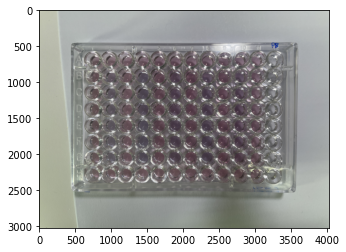

In [71]:
img_name = 'DA0638BF-B906-4461-8905-2446B3148611.png'#'6704FF24-1C79-4EF9-BDBD-25BE33015A3A.png'
full_path_to_file2 = os.path.join(img_name)
blob_service_client.get_blob_to_path('nano', full_path_to_file2, full_path_to_file2)
img = cv2.imread(img_name)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_RGB = RGB_img[500:2500,500:3500,:]
plt.imshow(new_RGB)
plt.imshow(RGB_img)

In [67]:
path = '/content/drive/MyDrive/NanoX/'

In [70]:
def get_X_Y(sheet,fcol=9,frows=(0,2)):
    data_pd = pd.read_excel('/content/drive/MyDrive/NanoX/Smartphone based sensor_19 August 2021.xlsx',sheet_name=sheet)
    fnames = list(data_pd.iloc[frows[0]:frows[1]+1,fcol])
    Y = list(data_pd.iloc[12,3:12:2])
    Y_list = list()
    X_list = list()
    for fname in fnames:
        print(fname)
        try:
            if fname[-4:] == '.png':
                out,X = get_colour_R(fname)
            else:
                out,X = get_colour_R(fname+'.png')
            X_list.append(X)
            Y_list += Y
        except:
            print(f'{fname} not found')
    return np.concatenate(X_list,axis=0),Y_list

In [108]:
def get_X_Y_(sheet,fcol=9,frows=(0,3)):
    data_pd = pd.read_excel('/content/drive/MyDrive/NanoX/Smartphone based sensor_19 August 2021.xlsx',sheet_name=sheet)
    fnames = list(data_pd.iloc[frows[0]:frows[1]+1,fcol])
    Y = list(data_pd.iloc[12,3:12:2])
    Y_list = list()
    X_list = list()
    for fname in fnames:
        print(fname)
        try:
            if fname[-4:] == '.png':
                out,X = get_colour_R(fname)
            else:
                out,X = get_colour_R(fname+'.png')
            X_list.append(X)
            Y_list += Y
        except:
            print(f'{fname} not found')
    return np.concatenate(X_list,axis=0),Y_list

0
6704FF24-1C79-4EF9-BDBD-25BE33015A3A.png
DA0638BF-B906-4461-8905-2446B3148611.png
AD52FD2E-B239-474F-A673-F54C8D5CF5E3.png


Client-Request-ID=0c36ed7e-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:05:48 GMT, Server-Request-ID=538cea9a-701e-001b-4391-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538cea9a-701e-001b-4391-95ef00000000Time:2021-08-20T07:05:48.9128912Z</Message></Error>.


1
54A75DB0-BB4F-45F9-9667-5494F-83997D1.png
54A75DB0-BB4F-45F9-9667-5494F-83997D1.png not found
5E136F1E-E14C-416B-827C-9344B1FCDFDD.png
BB65C105-B77B-4C16-A197-B173830980CA.png


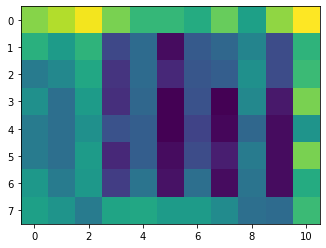

In [113]:
Table=[]
for i in range(2):
    print(i)
    X1,Y1 = get_X_Y(i)
    for k in range(len(X1)):
        Table.append({'Sheet':i, 'X':X1[k], 'Y':Y1[k]})

2
5A57F9B7-DC5F-4FB7-9CF3-5306913042DB.png
E2487A69-C406-445B-922F-7450A6EA478B.png
A049F8AB-10C2-4603-A963-9D31491FC81B.png
EBD557FF-33BF-4A04-8942-DB671A08E1F5.png
3
849ECEE1-8300-491E-BFAF-2068AFAECC6F
809BA82F-4F53-4F09-A89C-6D7A64129B15
2071E1C6-3A18-4CFF-B44D-72EF3A9FDDF3


Client-Request-ID=0fab711e-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:05:54 GMT, Server-Request-ID=538cf739-701e-001b-2691-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538cf739-701e-001b-2691-95ef00000000Time:2021-08-20T07:05:54.7270337Z</Message></Error>.


5794A292-941A-4D50-AC34-79D06BE19E1
5794A292-941A-4D50-AC34-79D06BE19E1 not found
4
3680E0CE-8AC9-406F-AD62-8069EEDEC3EC
2FEE8A2B-5C12-4E86-86E4-882DCE6C3DC3
D6E53277-2C6E-421D-B9D5-2127108FB58D


Client-Request-ID=10b6b65e-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:05:56 GMT, Server-Request-ID=538cfba6-701e-001b-3f91-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538cfba6-701e-001b-3f91-95ef00000000Time:2021-08-20T07:05:56.4602736Z</Message></Error>.
Client-Request-ID=10c6979a-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:05:56 GMT, Server-Request-ID=538cfbe3-701e-001b-7991-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538cfbe3-701e-001b-7991-95ef00000000Time:2021-08-20T07:05:56.5743538Z</Message></Error>

DF9E2333-6456-4889-8E7C-F339B9E5746
DF9E2333-6456-4889-8E7C-F339B9E5746 not found
5
E7F14D2A-7C11-43D9-AEOB-OEA7E7DE820D
E7F14D2A-7C11-43D9-AEOB-OEA7E7DE820D not found
B96D2931-24B6-4017-BBE5-40BF0973F6C7
6A6DC13C-4EBB-406E-AA33-A731AAB598EA
59D931C2-E09F-4B33-A579-715D323B1374
6
9807749F-2354-4156-A37B-8A55437D16B3
03E32800-5001-4B35-9538-3A18156D0938
F288DD01-8CBD-4167-A3EB-310194156A9A
978E3863-63D8-4861-82CD-569B59DCE9C2
7
7B7A43B1-FF91-4C56-8EB5-9CAE6AD3B47D
44DD2466-82A6-4839-993A-0C754B50C6DD


Client-Request-ID=15023756-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:03 GMT, Server-Request-ID=538d0aea-701e-001b-5991-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d0aea-701e-001b-5991-95ef00000000Time:2021-08-20T07:06:03.6674060Z</Message></Error>.


139C5E96-79E1-45A6-BEE9-1808F6C96E04
139C5E96-79E1-45A6-BEE9-1808F6C96E04 not found
3B00624D-A893-4D44-B69E-6704B79422B1


Client-Request-ID=157dbe8a-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:04 GMT, Server-Request-ID=538d0c76-701e-001b-3591-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d0c76-701e-001b-3591-95ef00000000Time:2021-08-20T07:06:04.4839909Z</Message></Error>.


8
9CE3E328-C94B-4A59-BDB1-208CC62AAEE4
9CE3E328-C94B-4A59-BDB1-208CC62AAEE4 not found
D11E850A-2FD0-47A5-A3B2-DC82522A7515
2019E45A-B173-4609-BDA6-2669EED7D100
58BE00ED-B1BE-46C9-B608-847F0788B4AF
9
A9F1AC29-D498-4EC5-9E5E-05296369DD66
B30B9F44-FF42-432E-ABC3-BB8600A212F8
A9A1A828-E34E-464B-AC5B-551B9CF7EABE


Client-Request-ID=17ce664e-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:08 GMT, Server-Request-ID=538d166e-701e-001b-0391-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d166e-701e-001b-0391-95ef00000000Time:2021-08-20T07:06:08.3617518Z</Message></Error>.


FFE0CCA21-F61B-48A3-97E6-4882F90D4020
FFE0CCA21-F61B-48A3-97E6-4882F90D4020 not found
10
26EA8058-8462-43AD-A8A3-A6966C6B6D8F
76E0CA07-2C87-48E6-891D-166643C8F35E
A0551BED-BC3F-4C81-8A86-D49CC1DC88E4
C1A399A0-6280-4309-BC68-B63F9103359A
11
1626B915-E8D6-4E20-80AA-05B28D3C34F2


Client-Request-ID=1ba37264-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:14 GMT, Server-Request-ID=538d262d-701e-001b-2e91-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d262d-701e-001b-2e91-95ef00000000Time:2021-08-20T07:06:14.7993424Z</Message></Error>.


401CB17D-CFE2-49E1-E95D-D8385C1E6ACD
401CB17D-CFE2-49E1-E95D-D8385C1E6ACD not found
32D4D5F0-4617-4589-A4E7-E5067C0166F3
F1902C0C-349D-425F-BD7C-E05B6FE2E940
12
66133A70-8CB4-4DD0-9196-8100E83DD9FF


Client-Request-ID=1d3872c8-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:17 GMT, Server-Request-ID=538d2c42-701e-001b-5a91-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d2c42-701e-001b-5a91-95ef00000000Time:2021-08-20T07:06:17.4472275Z</Message></Error>.


3DB12E17-90224F59-83C5-490E0CC36FEB
3DB12E17-90224F59-83C5-490E0CC36FEB not found
4FD5AECC-EC9D-4F61-BC48-5CBA2CC3A101
7181F92B-76E5-49F9-B72F-887BCA907E46
13
16DCFEF3-9C62-478B-9D3A-FD5DCDA86316
FA187368-DB14-47B1-BB37-77E9BCA3257A
F05DB0C7-BE2D-493A-85BC-7FC440FE8514


Client-Request-ID=1f65a656-0185-11ec-a03c-0242ac1c0002 Retry policy did not allow for a retry: Server-Timestamp=Fri, 20 Aug 2021 07:06:20 GMT, Server-Request-ID=538d3502-701e-001b-0191-95ef00000000, HTTP status code=404, Exception=The specified blob does not exist. ErrorCode: BlobNotFound<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:538d3502-701e-001b-0191-95ef00000000Time:2021-08-20T07:06:21.0958293Z</Message></Error>.


7063C32E-F085-4A78-873D-E30EA30C3414
7063C32E-F085-4A78-873D-E30EA30C3414 not found
14
DF550EE5-ACF6-4423-97EB-E0CB396A2F2F
FAD171C0-F011-49F3-9783-B81C6EFFDC1D
EC2F88EB-BF41-491B-99FC-AA44E591EEFE
50368D6F-9BEC-443E-877E-64D5CB097E78


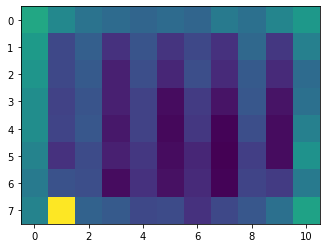

In [114]:
for i in range(2,15):
    print(i)
    X1,Y1 = get_X_Y_(i)
    for k in range(len(X1)):
        Table.append({'Sheet':i, 'X':X1[k], 'Y':Y1[k]})

In [123]:
# X1,Y1 = get_X_Y_(14)

In [116]:
Abndf = pd.DataFrame(Table)
Abndf_ = Abndf[Abndf['Y'] != -5]

In [117]:
print('Data all: ', len(Abndf))
print('Data After remove "-5": ', len(Abndf_))

Data all:  240
Data After remove "-5":  135


In [145]:
x = Abndf_['X'].tolist()
y = Abndf_['Y'].tolist()
sheet = Abndf_['Sheet'].tolist()

In [146]:
import pandas as pd 
# List1 
df = pd.DataFrame(x, dtype = float) 
df['Sheet'] =sheet
df['Y'] =y

In [147]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Sheet,Y
0,113.0,118.0,118.0,107.0,105.0,109.0,92.0,95.0,104.0,96.0,90.0,98.0,92.0,90.5,95.0,94.0,89.0,99.0,99.0,92.0,97.0,103.0,100.0,95.0,0,-1
1,118.0,109.0,103.0,109.0,80.0,89.0,104.0,76.0,90.0,98.0,75.0,85.0,95.0,79.0,82.0,99.0,75.0,83.0,97.0,78.0,89.0,95.0,102.0,102.0,0,1
2,103.0,106.0,98.0,89.0,76.0,90.0,90.0,81.0,86.0,85.0,72.0,80.0,82.0,71.0,81.0,83.0,67.0,78.0,89.0,70.0,85.0,102.0,100.0,99.0,0,-1
3,98.0,110.0,101.0,90.0,88.0,94.0,86.0,84.0,96.0,80.0,69.0,93.0,81.0,68.0,87.0,78.0,70.0,87.0,85.0,70.0,88.0,99.0,96.0,91.0,0,1
4,101.0,112.0,119.0,94.0,87.0,104.0,96.0,87.0,109.0,93.0,75.0,108.0,87.0,77.0,96.0,87.0,75.0,109.0,88.0,80.0,101.0,91.0,92.0,102.0,0,-1


In [148]:
# os.chdir( '/content/drive/MyDrive/NanoX/')
# df.to_csv('NanoX_Fv_all.csv')